# Notebook for Supervised ML: Classifying astronomical objects

Analyses based on paper: Clarke, A. O., Scaife, A. M. M., Greenhalgh, R. & Griguta, V. (2020). Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra. Astronomy & Astrophysics, 639, A84. https://doi.org/10.1051/0004-6361/201936770

Assisted by ChatGPT (30 Sept 2025)

## Set up working tree and load packages

In [33]:
# load relevant packages:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

import numpy as np
import pickle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# load data:
(tsne_subsample,tsne_subsample_classes) = pickle.load( open( "Dataset_galaxies_quasars_stars/subdf_unsupervised.pickle", "rb" ))

In [35]:
print( np.unique( tsne_subsample_classes ))
for o in ['STAR','GALAXY','QSO']:
    print( o )
    print( np.round( tsne_subsample[ np.where(tsne_subsample_classes==o)[0][:2] ], 3 ) )

['GALAXY' 'QSO' 'STAR']
STAR
[[2.1529e+01 1.8571e+01 1.7199e+01 1.6525e+01 1.6147e+01 1.4014e+01
  1.4036e+01 1.3286e+01 9.1180e+00 3.0000e-03]
 [1.9190e+01 1.7982e+01 1.7467e+01 1.7235e+01 1.7123e+01 1.5295e+01
  1.5094e+01 1.2837e+01 9.1740e+00 5.0000e-03]]
GALAXY
[[21.36  20.022 19.495 19.128 18.878 14.604 14.425 11.079  8.945  2.411]
 [22.783 22.479 21.295 20.391 22.827 13.546 13.588 11.999  9.046  0.628]]
QSO
[[2.0617e+01 2.0084e+01 2.0109e+01 2.0126e+01 1.9884e+01 1.7075e+01
  1.5981e+01 1.3118e+01 8.8840e+00 1.4000e-02]
 [1.9939e+01 1.9849e+01 1.9543e+01 1.9615e+01 1.9629e+01 1.5371e+01
  1.4206e+01 1.1351e+01 9.3030e+00 7.0000e-03]]


In [37]:
# --------------------- Set up data for crossvalidation ---------------------

# Splitting the dataset into train and test
# (set random_state to make split reproducible)
X_train, X_test, y_train, y_test = train_test_split(tsne_subsample,
                                                    tsne_subsample_classes,
                                                    test_size=0.4,
                                                    random_state=42)

# generate test and validation:
X_val, X_test, y_val, y_test = train_test_split(X_test,
                                                    y_test,
                                                    test_size=0.5,
                                                    random_state=42)

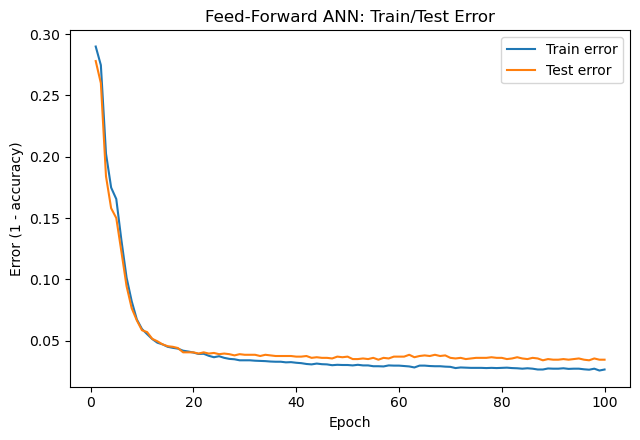

Final Train Error: 0.026
Final Test Error : 0.034


In [39]:
# --- Define MLP ---
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # two hidden layers
    activation='relu',
    solver='adam',
    alpha=1e-4,
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=1,         # we will control epochs manually
    warm_start=False,
    shuffle=True,
    random_state=42,
    verbose=False
)

n_epochs = 100
train_err, test_err = [], []

for epoch in range(n_epochs):
    if epoch == 0:
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))
    else:
        mlp.partial_fit(X_train, y_train)

    # Errors
    train_acc = accuracy_score(y_train, mlp.predict(X_train))
    test_acc  = accuracy_score(y_test,  mlp.predict(X_test))
    train_err.append(1.0 - train_acc)
    test_err.append(1.0 - test_acc)

# --- Plot train/test error vs. epochs ---
plt.figure(figsize=(6.5, 4.5))
plt.plot(range(1, n_epochs+1), train_err, label="Train error")
plt.plot(range(1, n_epochs+1), test_err, label="Test error")
plt.xlabel("Epoch")
plt.ylabel("Error (1 - accuracy)")
plt.title("Feed-Forward ANN: Train/Test Error")
plt.legend()
plt.tight_layout()
plt.savefig("ann_train_test_error.png", dpi=200, bbox_inches="tight")
plt.show()

print("Final Train Error: {:.3f}".format(train_err[-1]))
print("Final Test Error : {:.3f}".format(test_err[-1]))

In [40]:
# --- Classification report as dict ---
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98      1444
         QSO       0.93      0.88      0.90       240
        STAR       0.98      0.92      0.95       316

    accuracy                           0.97      2000
   macro avg       0.96      0.93      0.94      2000
weighted avg       0.97      0.97      0.97      2000



## Double-descent

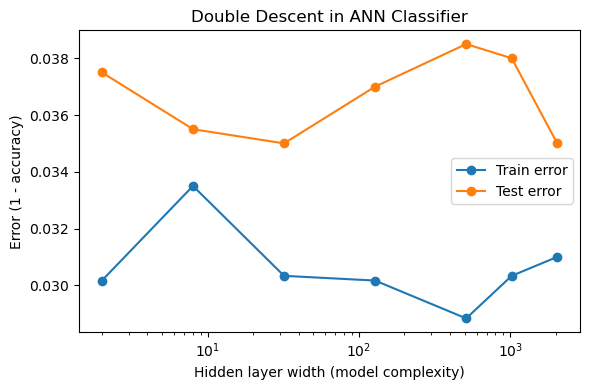

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

widths = [2, 8, 32, 128, 512, 1024, 2**11]
train_err, test_err = [], []

for w in widths:
    mlp = MLPClassifier(
        hidden_layer_sizes=(w,),   # single hidden layer with variable width
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, mlp.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, mlp.predict(X_test)))

plt.figure(figsize=(6,4))
plt.plot(widths, train_err, marker='o', label='Train error')
plt.plot(widths, test_err, marker='o', label='Test error')
plt.xscale('log')
plt.xlabel("Hidden layer width (model complexity)")
plt.ylabel("Error (1 - accuracy)")
plt.title("Double Descent in ANN Classifier")
plt.legend()
plt.tight_layout()
plt.show()

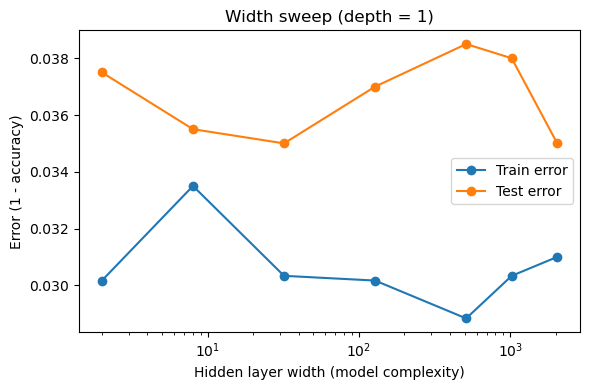

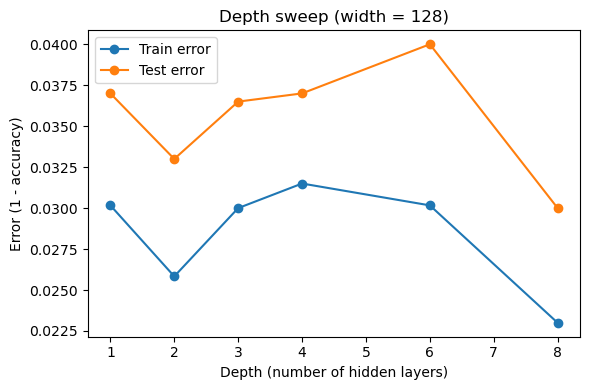

depth= 1, width=   2 -> train_err=0.030, test_err=0.037
depth= 1, width=   8 -> train_err=0.033, test_err=0.035
depth= 1, width=  32 -> train_err=0.030, test_err=0.035
depth= 1, width= 128 -> train_err=0.030, test_err=0.037
depth= 1, width= 512 -> train_err=0.029, test_err=0.038
depth= 1, width=1024 -> train_err=0.030, test_err=0.038
depth= 2, width=   2 -> train_err=0.290, test_err=0.278
depth= 2, width=   8 -> train_err=0.048, test_err=0.059
depth= 2, width=  32 -> train_err=0.031, test_err=0.042
depth= 2, width= 128 -> train_err=0.026, test_err=0.033


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ----------------------------
# 1) Width sweep (depth = 1)
# ----------------------------
widths = [2, 8, 32, 128, 512, 1024, 2**11]  # same as your list
train_err_w, test_err_w = [], []

for w in widths:
    mlp = MLPClassifier(
        hidden_layer_sizes=(w,),   # single hidden layer
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        shuffle=True,
        verbose=False
    )
    mlp.fit(X_train, y_train)
    train_err_w.append(1.0 - accuracy_score(y_train, mlp.predict(X_train)))
    test_err_w.append(1.0 - accuracy_score(y_test,  mlp.predict(X_test)))

plt.figure(figsize=(6,4))
plt.plot(widths, train_err_w, marker='o', label='Train error')
plt.plot(widths, test_err_w, marker='o', label='Test error')
plt.xscale('log')
plt.xlabel("Hidden layer width (model complexity)")
plt.ylabel("Error (1 - accuracy)")
plt.title("Width sweep (depth = 1)")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 2) Depth sweep (fixed width)
# ----------------------------
fixed_width = 128
depths = [1, 2, 3, 4, 6, 8]
train_err_d, test_err_d = [], []

for d in depths:
    hidden = tuple([fixed_width]*d)
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden,
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42,
        shuffle=True,
        verbose=False
    )
    mlp.fit(X_train, y_train)
    train_err_d.append(1.0 - accuracy_score(y_train, mlp.predict(X_train)))
    test_err_d.append(1.0 - accuracy_score(y_test,  mlp.predict(X_test)))

plt.figure(figsize=(6,4))
plt.plot(depths, train_err_d, marker='o', label='Train error')
plt.plot(depths, test_err_d, marker='o', label='Test error')
plt.xlabel("Depth (number of hidden layers)")
plt.ylabel("Error (1 - accuracy)")
plt.title(f"Depth sweep (width = {fixed_width})")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# 3) Joint sweep: width × depth grid + contour/heatmaps
# ---------------------------------------------------------
# NOTE: Very large widths x deep nets can be slow. Adjust as needed.
grid_widths = [2, 8, 32, 128, 512, 1024]   # you can include 2048 if runtime allows
grid_depths = [1, 2, 3, 4, 6]              # extend if you want

W = len(grid_widths)
D = len(grid_depths)
err_train = np.zeros((D, W))
err_test  = np.zeros((D, W))

for i, d in enumerate(grid_depths):
    for j, w in enumerate(grid_widths):
        hidden = tuple([w]*d)
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden,
            activation='relu',
            solver='adam',
            max_iter=500,
            random_state=42,
            shuffle=True,
            verbose=False
        )
        mlp.fit(X_train, y_train)
        err_train[i, j] = 1.0 - accuracy_score(y_train, mlp.predict(X_train))
        err_test[i, j]  = 1.0 - accuracy_score(y_test,  mlp.predict(X_test))
        print(f"depth={d:>2}, width={w:>4} -> train_err={err_train[i,j]:.3f}, test_err={err_test[i,j]:.3f}")

# Plot as heatmaps with contours (x=width, y=depth)
width_ticks = np.arange(W)
depth_ticks = np.arange(D)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
# Train error
im0 = axes[0].imshow(err_train, origin='lower', aspect='auto', cmap='viridis')
cs0 = axes[0].contour(err_train, colors='w', linewidths=0.8, levels=6)
axes[0].clabel(cs0, inline=True, fontsize=8)
axes[0].set_xticks(width_ticks); axes[0].set_xticklabels([str(w) for w in grid_widths], rotation=45)
axes[0].set_yticks(depth_ticks); axes[0].set_yticklabels([str(d) for d in grid_depths])
axes[0].set_xlabel("Width (neurons per hidden layer)")
axes[0].set_ylabel("Depth (number of hidden layers)")
axes[0].set_title("Train error (1 - accuracy)")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Test error
im1 = axes[1].imshow(err_test, origin='lower', aspect='auto', cmap='viridis')
cs1 = axes[1].contour(err_test, colors='w', linewidths=0.8, levels=6)
axes[1].clabel(cs1, inline=True, fontsize=8)
axes[1].set_xticks(width_ticks); axes[1].set_xticklabels([str(w) for w in grid_widths], rotation=45)
axes[1].set_yticks(depth_ticks); axes[1].set_yticklabels([str(d) for d in grid_depths])
axes[1].set_xlabel("Width (neurons per hidden layer)")
axes[1].set_ylabel("Depth (number of hidden layers)")
axes[1].set_title("Test error (1 - accuracy)")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()